In this part of the tutorial, we will be using a pre-trained model to perform some inference and detect anomalies in the pixel occupancy plots. This pre-trained model is based on residual networks (see [K. He et al, arXiv:1512.03385](https://arxiv.org/abs/1512.03385) for more info) and is constructed in the form of autoencoders in the same way as in the previous part. Unlike the 1D autoencoder we saw earlier, this model is a 2D autoencoder that accepts 2D histograms.

# What we need
- Four model files in hdf5 format.
- ZeroBias rate for **2022F** lumisections, obtained from OMS. We need this to normalise the histograms as inputs to the model.

# Workflow in a nutshell
- Preprocess the histograms
    - Make sure that the histogram has the dimension of 200 x 140. We may have to trim it.
    - Normalise the histograms with a corresponding ZeroBias rate for each lumisection from OMS.
- Run the model
    - Reconstruct all four histograms per each lumisection
        - Input: histogram of 200 x 140
        - Output: _reconstructed_ histogram of 200 x 140
- Interpret the reconstruction
    - For each histogram in a lumisection, 
        - calculate the difference using MSE, then
        - calculate the mean of MSE from all pixels. 
        - We should have four numbers representing MSE loss for four histograms in each lumisection.
    - Perform PCA on a tuple of four numbers from all lumisections we have.

# Prerequisite packages and setups

In [1]:
# To avoid bugs in TensorFlow 2.6.0, we will instead use TensorFlow 2.6.2
# The bug: https://stackoverflow.com/questions/69694944/how-to-fix-error-cannot-register-2-metrics-with-the-same-name-tensorflow-api
!pip install tensorflow==2.6.2

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Prerequisite packages
import pickle
import numpy as np
import tensorflow as tf
import ROOT
import sklearn.preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
import os
import tqdm

Welcome to JupyROOT 6.24/08


In [3]:
!pip install mplhep
import mplhep as hep
plt.style.use([hep.style.CMS])
hep.rcParams.label.data = True
hep.rcParams.label.paper = True
hep.rcParams.label.llabel = "Preliminary"
hep.rcParams.label.lumi = None
hep.rcParams.label.year = 2017

Defaulting to user installation because normal site-packages is not writeable


In this tutorial, we will follow suit and use nanoDQMIO file format, which conveniently stores 2D histograms in addition to 1D histograms.

In [4]:
# Assuming that you have DQMIOReader class set up from the previous tutorial...
# But if you don't, use the following command:
# ! curl https://raw.githubusercontent.com/LukaLambrecht/ML4DQMDC-PixelAE/41ab87a8c3fe96677329fda437eb168da6bd1e60/dqmio/src/DQMIOReader.py > DQMIOReader.py
from DQMIOReader import DQMIOReader

In [5]:
# We will read ALL nanoDQMIO files available simultaneously.
filenames = [os.path.join("/nfs/dust/cms/group/cmsdas2023/TRK-DQM/ZeroBias_Run2022F_DQMIO", f) \
             for f in os.listdir("/nfs/dust/cms/group/cmsdas2023/TRK-DQM/ZeroBias_Run2022F_DQMIO") if f[0] != '.']
dqmio_reader = DQMIOReader(*filenames)
dqmio_runs = pd.DataFrame(sorted(dqmio_reader.listLumis()), columns=["run_number", "lumisection_number"])

DQMIOReader.__init__: opening 64 files...
all files opened, now making index
index made, now making list of monitoring elements


The model we will be using here expects the input data to be normalised by ZeroBias HLT dataset rate, so we should obtain it as well. One way to do this is to use OMS API provided by Luka Lambrecht here: https://github.com/LukaLambrecht/ML4DQMDC-PixelAE/tree/master/omsapi. However, the API requires a client ID and a secret (pretty much like passwords), which can be obtained by registering an application ID with OMS developer team. You can have a look at the README file for the linked repo for more details.

As you might realise by now, we do not have time to set everything up, especially contacting OMS developer team (who are humans) to set up application IDs for all participants. So instead of using the API, we have prepared the JSON file containing ZeroBias and L1Accept dataset HLT rates. We will be using only ZeroBias here, so we have to strip and clean the ZeroBias database we have.

In [6]:
oms_rate = pd.read_json("/nfs/dust/cms/group/cmsdas2023/TRK-DQM-DQMIO-exercise/rate_era_Run2022F.json")
oms_runs_withrate = oms_rate[~oms_rate["rate_ZeroBias"].isna()][["run_number", "lumisection_number", "rate_ZeroBias"]]
oms_runs_withrate = oms_runs_withrate.sort_values(by=["run_number", "lumisection_number"])

In [7]:
oms_runs_withrate

run_number  lumisection_number  rate_ZeroBias
131         360335                   1       8.622757
132         360335                   2       9.266246
133         360335                   3       9.266246
134         360335                   4       9.695239
135         360335                   5      10.038434
...            ...                 ...            ...
111320      362167                 652      80.135872
111321      362167                 653      24.538393
111322      362167                 654       9.437844
111323      362167                 655       4.633123
111324      362167                 656       1.158281

[67015 rows x 3 columns]

We will also have to check which runs are available in our nanoDQMIO files, so...

In [8]:
datasetrate_df = pd.merge(oms_runs_withrate, dqmio_runs, how="inner", \
                          on=["run_number", "lumisection_number"]).sort_values(by=["run_number", "lumisection_number"])

In [9]:
datasetrate_df

run_number  lumisection_number  rate_ZeroBias
0          360390                   5     105.489352
1          360390                   6     106.390237
2          360390                   7     106.004143
3          360390                   8     104.159474
4          360390                   9     107.848813
...           ...                 ...            ...
44344      362167                 642      78.033807
44345      362167                 643      81.422851
44346      362167                 644      79.663980
44347      362167                 645      78.462800
44348      362167                 646      79.663980

[44349 rows x 3 columns]

The final ingredient are the models. These models are trained by using data from **2017B** era, but as these models are designed for 2D histograms using convolutional 2D layers, retraining the models for **2022F** era will take a huge amount of processing power, something only specialised machines like IBM Minsky can provide.

For demonstration purposes, we will use these models as is.

In [10]:
models = [tf.keras.models.load_model(f"/nfs/dust/cms/group/cmsdas2023/TRK-DQM-DQMIO-exercise/resnet_minsky_zphi{i}_0.50_best.hdf5", \
                                     compile=False) for i in range(1, 5)]

2023-10-04 12:10:23.232456: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-10-04 12:10:23.232496: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-10-04 12:10:23.232519: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (batch1379.desy.de): /proc/driver/nvidia/version does not exist
2023-10-04 12:10:23.232702: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Preprocessing

In [11]:
def gethist(runnr, lumisection):
    zphi_temps = []
    rate_series = datasetrate_df[(datasetrate_df["run_number"] == runnr) & (datasetrate_df["lumisection_number"] == lumisection)]["rate_ZeroBias"].to_list()
    if len(rate_series) != 1: raise Exception("Rate for this lumisection is not available!")
    rate = rate_series[0]
    for zphicount in range(1, 5):
        histobj = dqmio_reader.getSingleMEForLumi((runnr, lumisection), f"PixelPhase1/Tracks/PXBarrel/clusterposition_zphi_ontrack_PXLayer_{zphicount}").data
        hist = np.zeros((histobj.GetNbinsY(), histobj.GetNbinsX()))
        for i in range(histobj.GetNbinsX()):
            for j in range(histobj.GetNbinsY()):
                hist[j, i] = histobj.GetBinContent(i+1, j+1)
        hist = hist[:, 80:220]/rate
        hist = np.reshape(hist, (-1, 200, 140, 1))
        zphi_temps.append(hist)
    return zphi_temps, rate

In [12]:
# The models are built using Keras, so you can see the structure of the network using summary method.
models[0].summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 140, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 200, 140, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 200, 140, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 200, 140, 16) 160         input_1[0][0]                    
____________________________________________________________________________________________

In [13]:
sample_lumi = gethist(360390, 5)

In [14]:
# The shape of one of the histograms
# We need the histograms to be in this shape since the model accepts inputs in (None, 200, 140, 1) shape.
sample_lumi[0][0].shape

(1, 200, 140, 1)

In [15]:
# ZeroBias rate of this lumisection
sample_lumi[1]

105.4893519378

In [16]:
# This model supports inputs that are normalised with ZeroBias rates,
# which we already did in the code above.
sample_input = [h for h in sample_lumi[0]]

In [17]:
sample_input[0].shape

(1, 200, 140, 1)

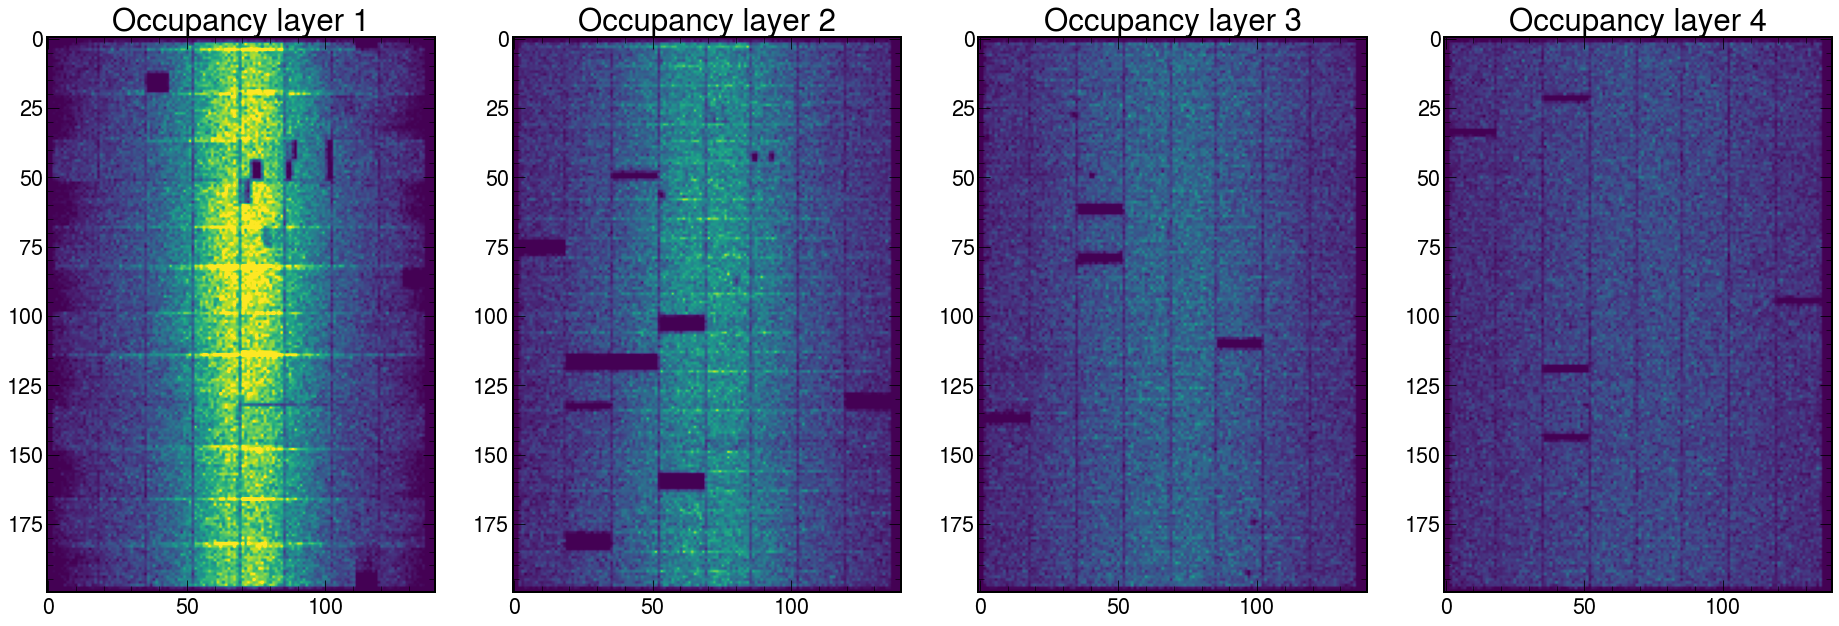

In [18]:
plt.figure(figsize=(32, 12))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(sample_input[i].reshape((200, 140)), vmin=0, vmax=0.5)
    plt.title(f"Occupancy layer {i+1}")

# Inference

In [19]:
# Since we already have a model, inference should be pretty simple.
sample_output = [model.predict(h) for (h, model) in zip(sample_input, models)]

2023-10-04 12:10:28.714307: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


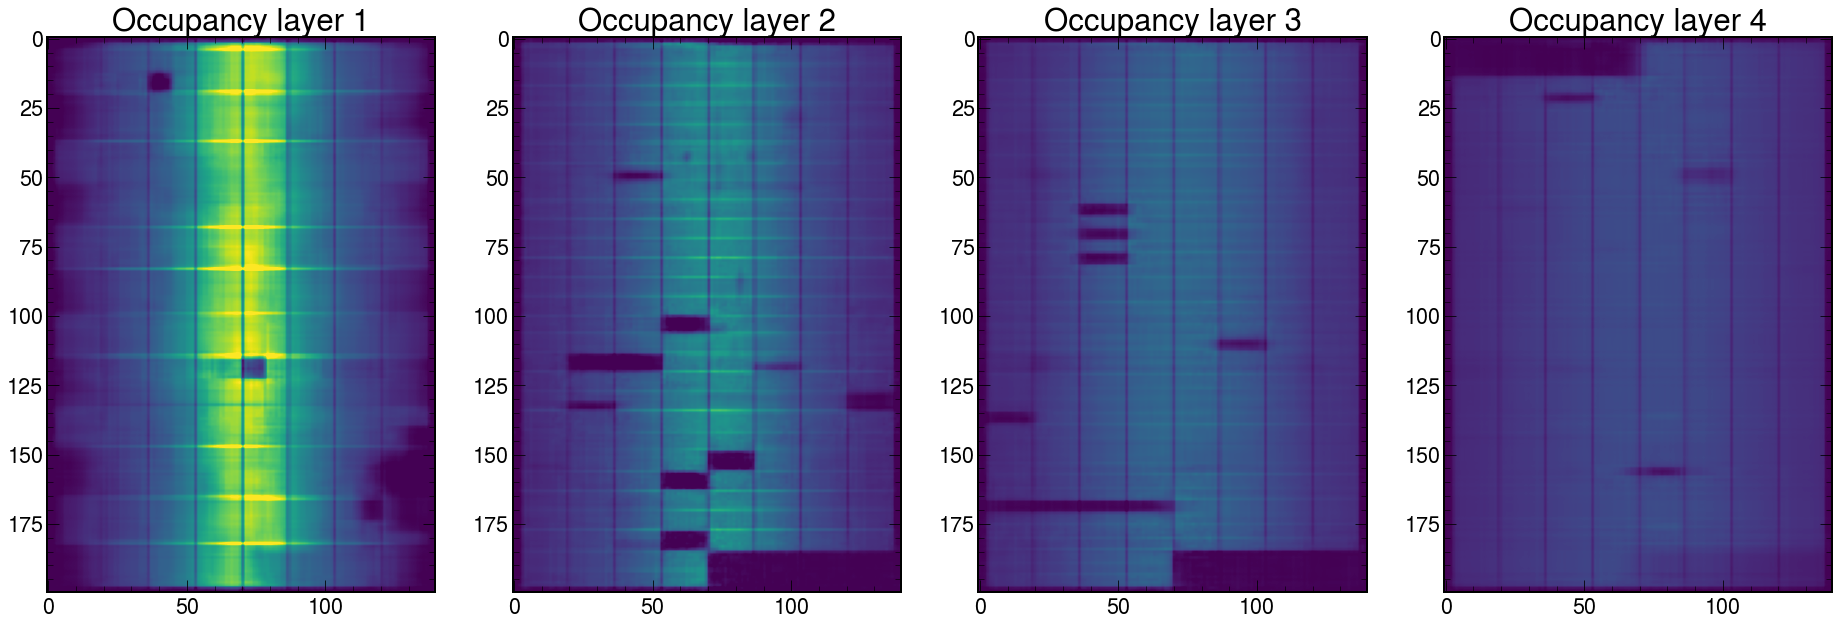

In [20]:
plt.figure(figsize=(32, 12))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(sample_output[i].reshape((200, 140)), vmin=0, vmax=0.5)
    plt.title(f"Occupancy layer {i+1}")

In [21]:
differences = [np.array(tf.keras.losses.mse(inputhist, outputhist)) for (inputhist, outputhist) in zip(sample_input, sample_output)]

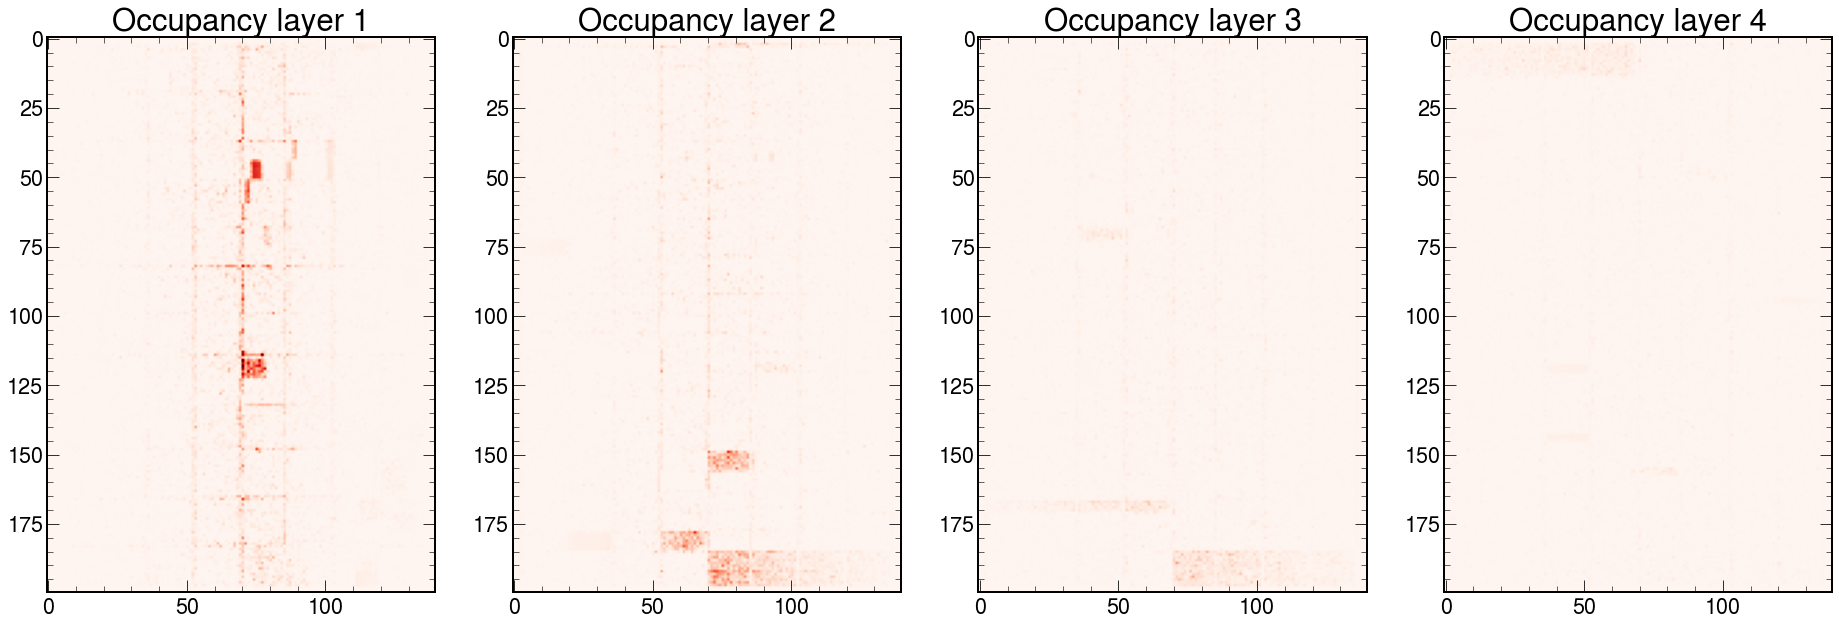

In [22]:
plt.figure(figsize=(32, 12))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(differences[i].reshape((200, 140)), vmin=0, vmax=0.25, cmap="Reds")
    plt.title(f"Occupancy layer {i+1}")

In [23]:
# We can also calculate mean of 
[np.mean(d) for d in differences]

[0.004018607, 0.003165248, 0.0018255757, 0.00123832]

With these reconstructions and differences, we can use them to summarise the reconstruction and see the error for any lumisection.

In [24]:
def plot_zphi_set(runnr, lumisection):
    FONTSIZE=15
    inputhists, rate = gethist(runnr, lumisection)
    mainfig = plt.figure(figsize=(20, 17), facecolor="white")
    #fig, axes = plt.subplots(nrows=3, ncols=4)
    #fig.tight_layout()
    plt.subplots_adjust(left=0.1, bottom=None, right=0.9, top=None, wspace=None, hspace=None)
    for i in range(4):
        outputhist = models[i].predict(inputhists[i])
        difference = tf.keras.losses.mse(inputhists[i], outputhist)
        
        outputhist = np.reshape(outputhist, (200, 140))
        difference = np.reshape(difference, (200, 140))
        
        ax = plt.subplot(3, 4, i+1)
        if i == 0: leftbound, _, mainfig_width, _ = plt.gca().get_position().bounds
        plot_truth = ax.imshow(inputhists[i].reshape(200, 140), vmin=0, vmax=0.5)
        plt.title(f"Barrel layer {i+1} original", fontsize=FONTSIZE)
        cbar = plt.colorbar(plot_truth)
        cbar.ax.set_ylabel("Normalised occupancy", fontsize=FONTSIZE)
        cbar.ax.tick_params(labelsize=FONTSIZE) 
        plt.tick_params(labelsize=FONTSIZE)
        plt.xticks(ticks=[70 + 140/56*i for i in range(-20, 21, 10)], labels=range(-20, 21, 10))
        plt.yticks(ticks=[100+100/3.2*i for i in np.arange(-3, 4, 1)], labels=range(-3, 4))
        plt.xlabel("Global z (cm)", fontsize=FONTSIZE)
        plt.ylabel("Global $\phi$", fontsize=FONTSIZE)
        #hep.cms.label(fontsize=FONTSIZE, loc=4)
        plt.gca().invert_yaxis()
        
        ax_pred = plt.subplot(3, 4, i+5)
        plot_pred = ax_pred.imshow(outputhist, vmin=0, vmax=0.5)
        cbar_reconstructed = plt.colorbar(plot_pred)
        cbar_reconstructed.ax.set_ylabel("Normalised occupancy", fontsize=FONTSIZE)
        cbar_reconstructed.ax.tick_params(labelsize=FONTSIZE) 
        plt.tick_params(labelsize=FONTSIZE)
        plt.xticks(ticks=[70 + 140/56*i for i in range(-20, 21, 10)], labels=range(-20, 21, 10))
        plt.yticks(ticks=[100+100/3.2*i for i in np.arange(-3, 4, 1)], labels=range(-3, 4))
        plt.title(f"Reconstructed", fontsize=FONTSIZE)
        plt.xlabel("Global z (cm)", fontsize=FONTSIZE)
        plt.ylabel("Global $\phi$", fontsize=FONTSIZE)
        #hep.cms.label(fontsize=FONTSIZE, loc=4)
        plt.gca().invert_yaxis()
        
        ax_mse = plt.subplot(3, 4, i+9)
        if i == 3: rightmost_leftbound, _, mainfig_width, _ = plt.gca().get_position().bounds
        plot_mse = ax_mse.imshow(difference, vmin=0, vmax=0.25, cmap="Reds")
        cbar_mse = plt.colorbar(plot_mse)
        cbar_mse.ax.set_ylabel("Mean squared error", fontsize=FONTSIZE)
        cbar_mse.ax.tick_params(labelsize=FONTSIZE) 
        plt.tick_params(labelsize=FONTSIZE)
        plt.xticks(ticks=[70 + 140/56*i for i in range(-20, 21, 10)], labels=range(-20, 21, 10))
        plt.yticks(ticks=[100+100/3.2*i for i in np.arange(-3, 4, 1)], labels=range(-3, 4))
        plt.title(f"MSE", fontsize=FONTSIZE)
        plt.xlabel("Global z (cm)", fontsize=FONTSIZE)
        plt.ylabel("Global $\phi$", fontsize=FONTSIZE)
        #plt.title(f"MSE: {MSE_mean:.6f}/{MSE_max:.6f}/{MSE_std:.6f}")
        #plt.colorbar()
        #hep.cms.label(fontsize=FONTSIZE, loc=0)
        plt.gca().invert_yaxis()
        
    cms_text = mainfig.text(leftbound, 0.92, "CMS", fontsize=FONTSIZE*1.3, fontweight='bold', horizontalalignment="left")
    mainfig.canvas.draw()
    #print(mainfig.get_size_inches())
    exp_offset = cms_text.get_window_extent().width/mainfig.dpi/mainfig.get_size_inches()[0]*1.05
    #print(exp_offset)
    mainfig.text(leftbound + exp_offset, 0.92, f"Run {runnr}, Lumisection {lumisection}", fontsize=FONTSIZE, style="italic", horizontalalignment="left")
    mainfig.text(rightmost_leftbound + mainfig_width, 0.92, "2017 (13 TeV)", fontsize=FONTSIZE, horizontalalignment="right")
    #plt.suptitle(f"Run {runnr}, Lumisection {lumisection}")
    #resnet_predict_and_compare(6, 297100, 229)

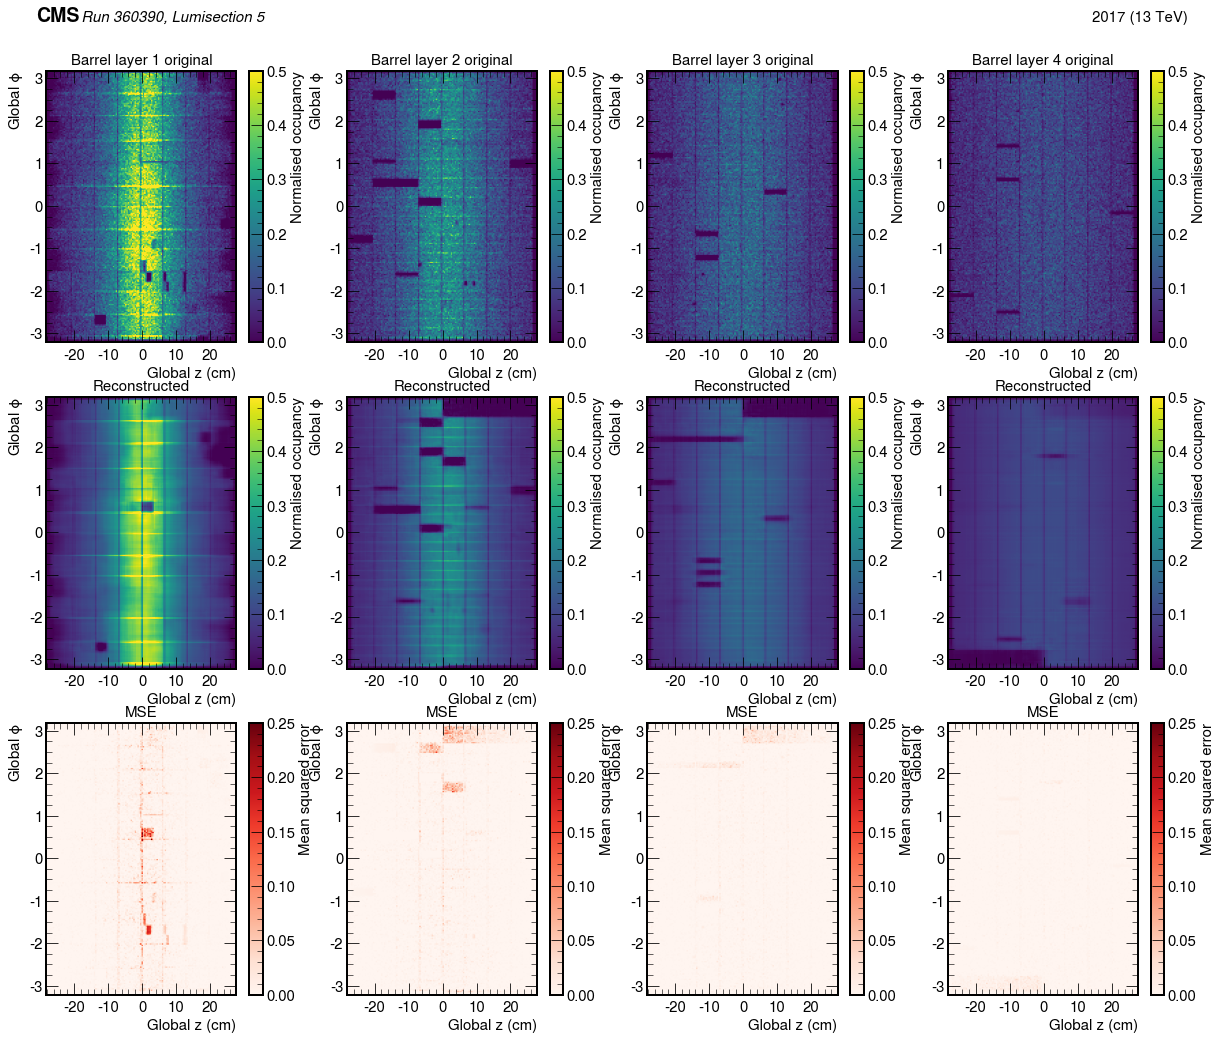

In [25]:
plot_zphi_set(360390, 5)

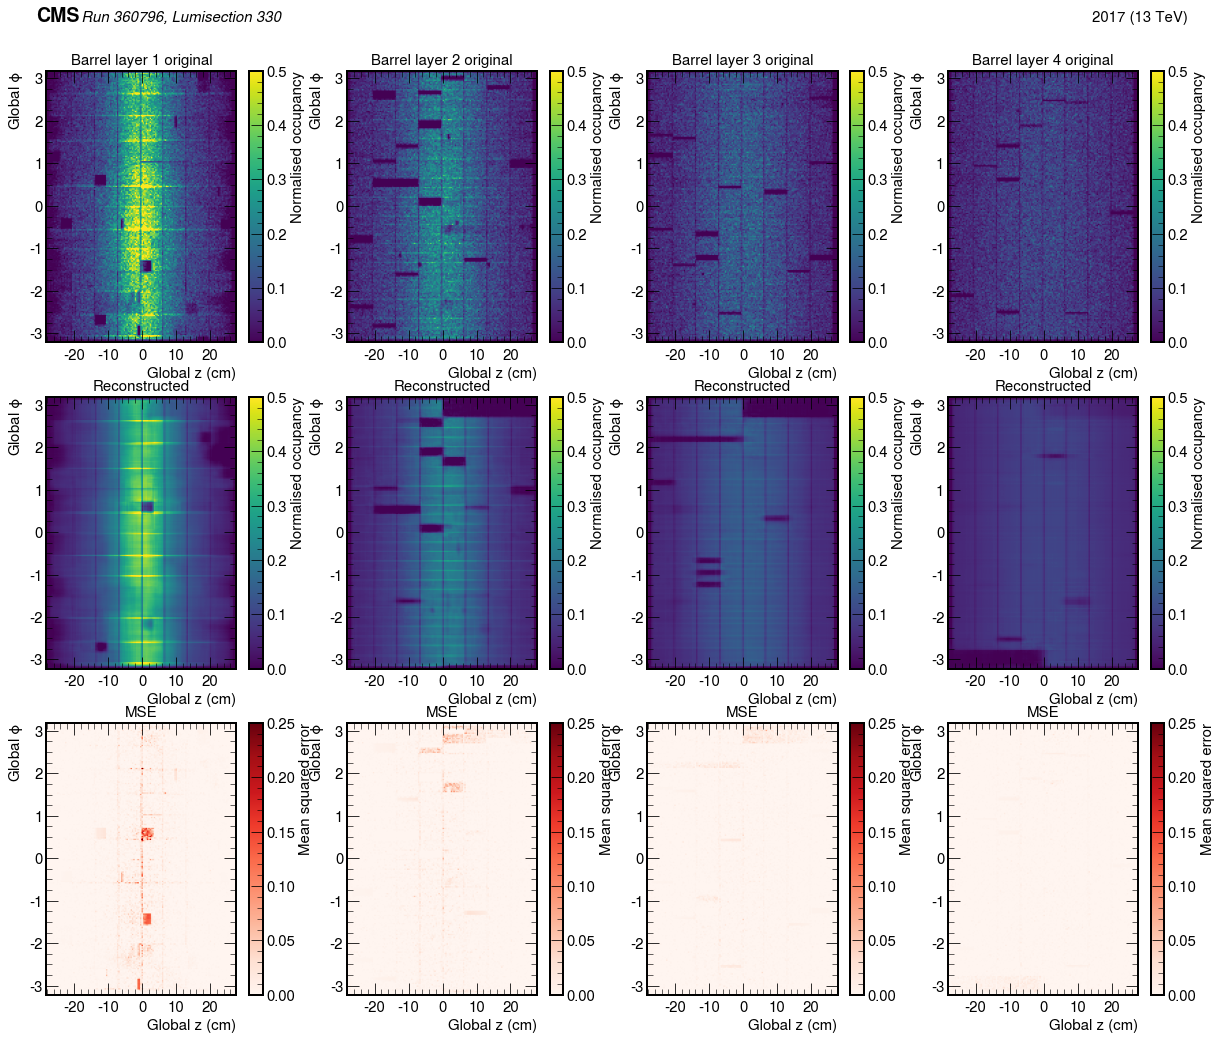

In [26]:
plot_zphi_set(360796, 330)

Given the tools we have right now, we can inspect if the lumisection we are interested in has any problems, which should be good for online monitoring. However, we would not be able to see which lumisection has problems unless we reconstruct a lot of lumisections and find anomalies among them. We will discuss about how to do that in the next ~lumisection~ section.

# Inference on several lumisections

The ultimate goal of autoencoders is to detect anomalies. This can be done by using the assumption that autoencoders will be able to reconstruct the histograms perfectly if the histogram itself does not have any issues, like a large portion of a subdetector does not work. On the other hand, it should reconstruct bad histograms poorly. This can be reflected with high reconstruction losses, which we already calculated as MSE.

We can also use the MSE information from each histogram from all lumisections and cluster them using unsupervised methods like PCA. In the example below, we will calculate MSE losses from four histograms in each lumisection, bundled them up as a four-dimensional tuple per lumisection, and throw them into PCA analysis.

In [27]:
differences_list = []
# To save time, we will limit ourselves at the first 5000 lumisections.
for _, row in tqdm.tqdm(datasetrate_df[:2000].iterrows(), total=2000, \
                        bar_format='Loading {n_fmt}/{total_fmt}, elapsed {elapsed}, ETA {remaining}'): 
    inputhists, _ = gethist(row["run_number"], row["lumisection_number"])
    reconstructed = [model.predict(h) for (h, model) in zip(inputhists, models)]
    differences = [np.array(tf.keras.losses.mse(inputhist, outputhist)) for (inputhist, outputhist) in zip(inputhists, reconstructed)]
    differences_list.append((int(row["run_number"]), int(row["lumisection_number"]), [np.mean(d) for d in differences]))

Loading 2000/2000, elapsed 14:23, ETA 00:00


In [28]:
differences_list

[(360390, 5, [0.004018607, 0.003165248, 0.0018255757, 0.00123832]),
 (360390, 6, [0.0042219507, 0.0032716796, 0.0018716311, 0.0012629128]),
 (360390, 7, [0.00414509, 0.0031334115, 0.0017861341, 0.0012363945]),
 (360390, 8, [0.004461235, 0.0032471167, 0.0018709943, 0.0012770216]),
 (360390, 9, [0.004162983, 0.0030792763, 0.0017925126, 0.0012011726]),
 (360390, 10, [0.0042001414, 0.0031321421, 0.0017926802, 0.0012586964]),
 (360390, 11, [0.0043597016, 0.003178355, 0.0018475888, 0.0012592344]),
 (360390, 12, [0.0044160667, 0.0031694053, 0.001865136, 0.0012473109]),
 (360390, 13, [0.004315908, 0.0031738149, 0.0017925045, 0.0012076302]),
 (360390, 14, [0.0043946467, 0.0031843921, 0.0018294968, 0.0012324819]),
 (360390, 15, [0.004391809, 0.0031298473, 0.0018290934, 0.0012532787]),
 (360390, 16, [0.0042878897, 0.00314328, 0.0018347473, 0.0012380477]),
 (360390, 17, [0.00439729, 0.0031521574, 0.0018297442, 0.0012552587]),
 (360390, 18, [0.004387483, 0.0031983708, 0.0018246444, 0.001272627]),
 

In [29]:
len(differences_list)

2000

We can quickly perform PCA on this list of a tuple containing mean MSE.

In [30]:
from sklearn.decomposition import PCA
pca_MSEmean_obj = PCA(n_components=2)
pca_MSEmean_obj.fit([a for _, _, a in differences_list])

PCA(n_components=2)

In [31]:
pca_MSEmean_obj.transform([a for _, _, a in differences_list])

array([[-8.96293291e-03, -1.17198946e-04],
       [-8.74411165e-03, -9.65917945e-05],
       [-8.91346266e-03, -1.12391942e-04],
       ...,
       [-1.16304566e-02, -3.41787971e-04],
       [-1.16156199e-02, -3.32792955e-04],
       [-1.16421418e-02, -3.50046649e-04]])

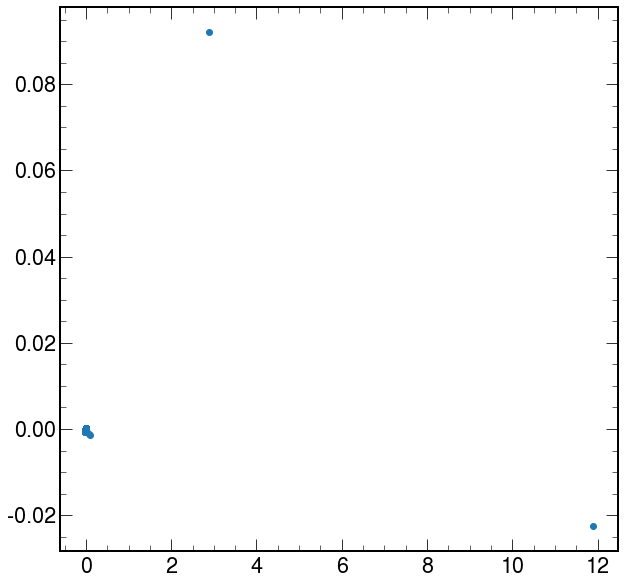

In [32]:
plt.scatter(*(pca_MSEmean_obj.transform([a for _, _, a in differences_list])).transpose())

What's interesting is that with PCA we can see two outliers. We can do a little investigation and see what these lumisections are.

In [33]:
differences_pca = np.column_stack(([[int(r), int(l)] for r, l, _ in differences_list], 
                                   pca_MSEmean_obj.transform([a for _, _, a in differences_list])
                                  ))

In [34]:
differences_pca

array([[ 3.60390000e+05,  5.00000000e+00, -8.96293291e-03,
        -1.17198946e-04],
       [ 3.60390000e+05,  6.00000000e+00, -8.74411165e-03,
        -9.65917945e-05],
       [ 3.60390000e+05,  7.00000000e+00, -8.91346266e-03,
        -1.12391942e-04],
       ...,
       [ 3.60460000e+05,  8.49000000e+02, -1.16304566e-02,
        -3.41787971e-04],
       [ 3.60460000e+05,  8.50000000e+02, -1.16156199e-02,
        -3.32792955e-04],
       [ 3.60460000e+05,  8.51000000e+02, -1.16421418e-02,
        -3.50046649e-04]])

In [35]:
[(r, l) for r, l, a1, a2 in differences_pca if a1 > 1]

[(360430.0, 1.0), (360433.0, 1.0)]

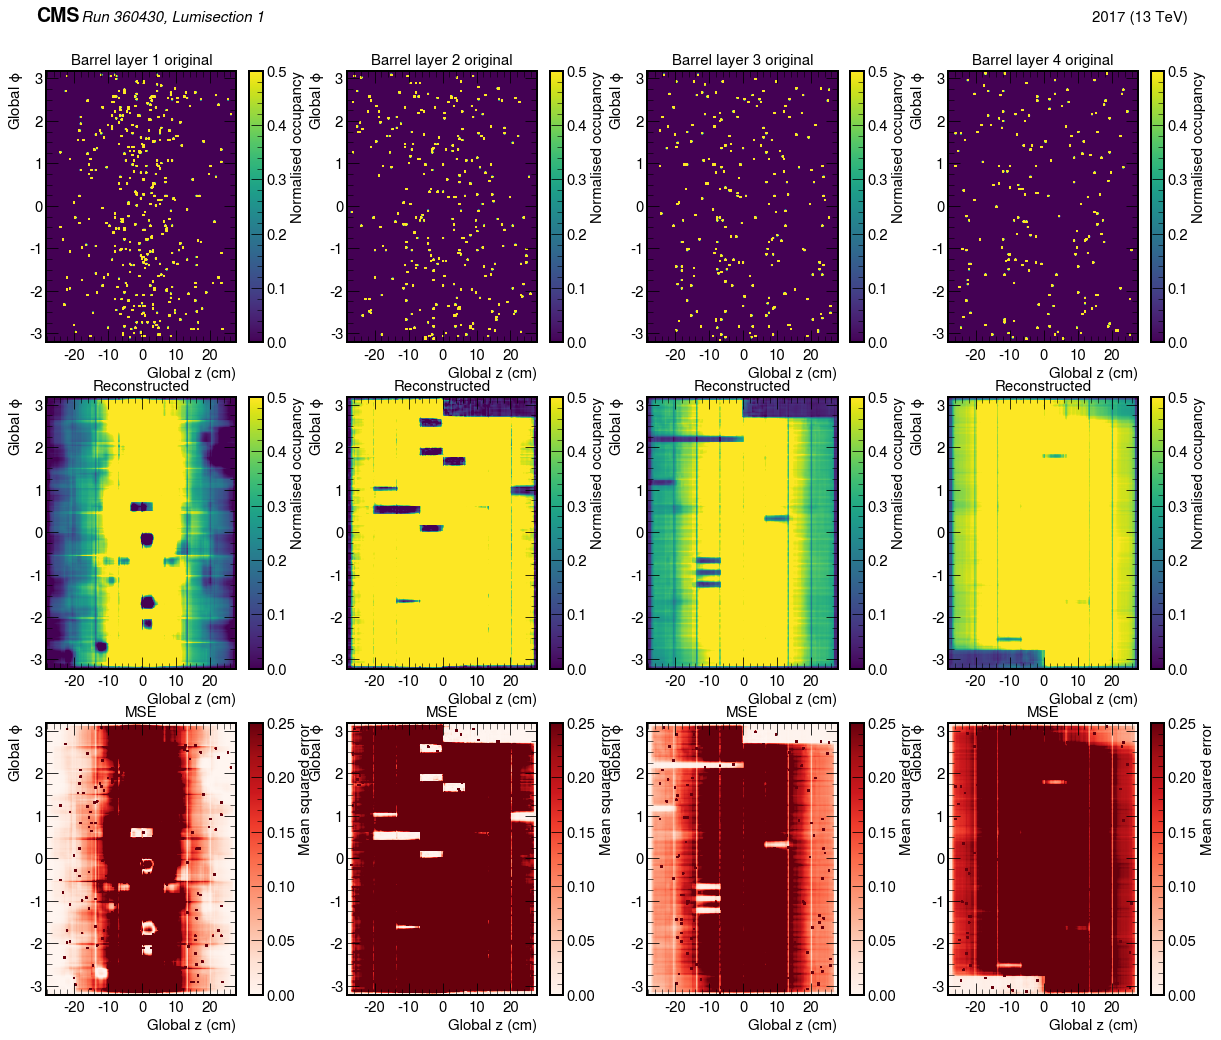

In [36]:
plot_zphi_set(360430, 1)

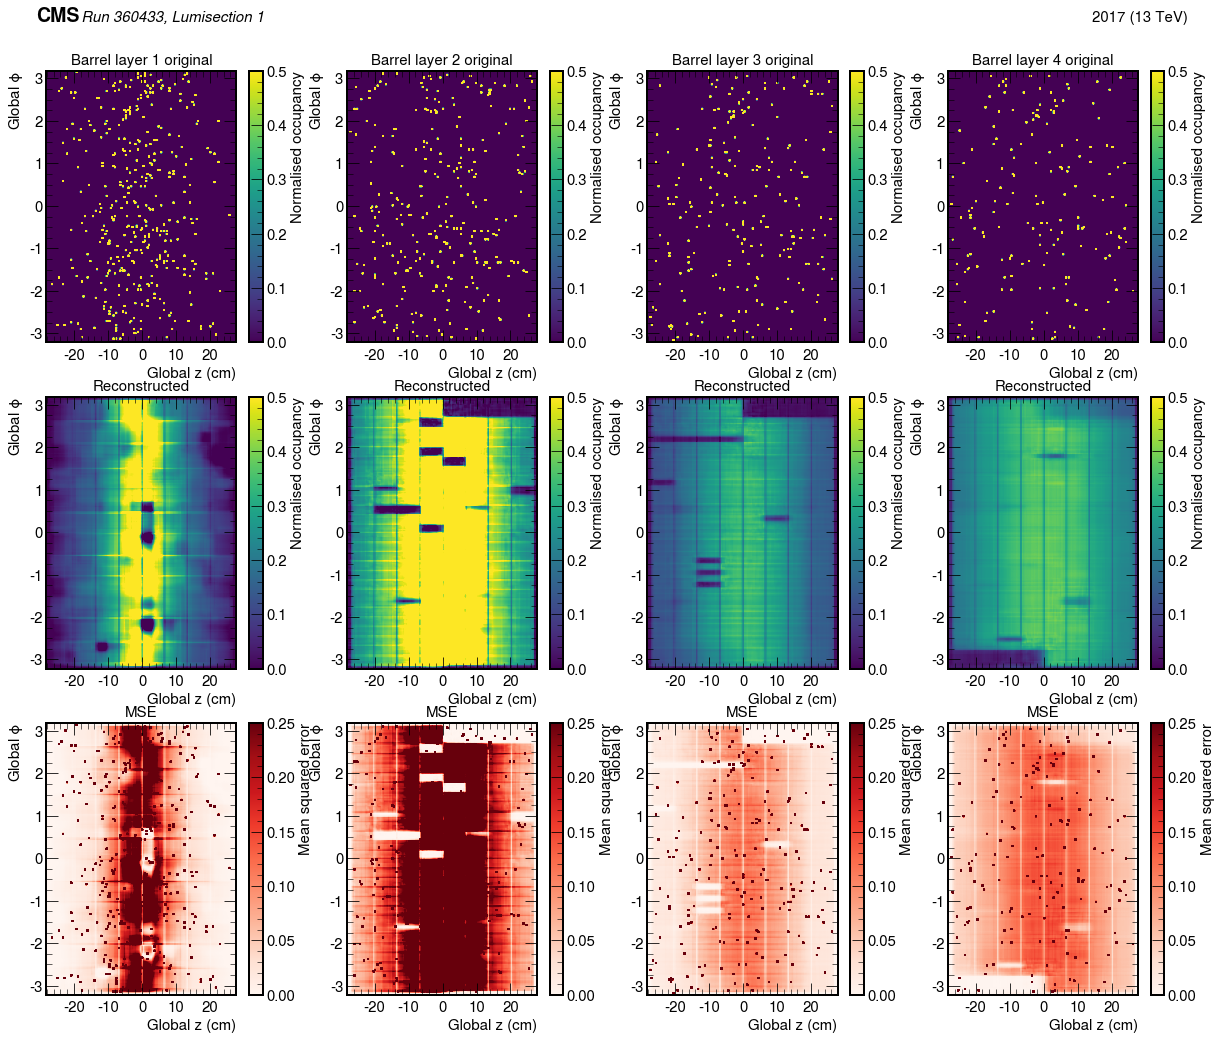

In [37]:
plot_zphi_set(360433, 1)

We can also zoom in to the region where a lot of lumisections cluster in the PCA plot and try to understand where and how they are clustered.

In [48]:
[(run, [r for r, _, a in differences_list].count(run)) for run in set([r for r, _, a in differences_list])]

[(360390, 78),
 (360391, 7),
 (360392, 62),
 (360393, 113),
 (360458, 201),
 (360459, 571),
 (360428, 74),
 (360460, 326),
 (360430, 1),
 (360400, 72),
 (360432, 28),
 (360433, 1),
 (360435, 41),
 (360437, 40),
 (360438, 61),
 (360439, 15),
 (360440, 6),
 (360441, 145),
 (360442, 102),
 (360413, 56)]

In [52]:
[(r, l) for r, l, _ in differences_list if r==360460]

[(360460, 426),
 (360460, 427),
 (360460, 428),
 (360460, 478),
 (360460, 479),
 (360460, 480),
 (360460, 481),
 (360460, 509),
 (360460, 510),
 (360460, 511),
 (360460, 512),
 (360460, 513),
 (360460, 514),
 (360460, 515),
 (360460, 516),
 (360460, 517),
 (360460, 521),
 (360460, 522),
 (360460, 523),
 (360460, 524),
 (360460, 525),
 (360460, 526),
 (360460, 527),
 (360460, 528),
 (360460, 529),
 (360460, 530),
 (360460, 531),
 (360460, 532),
 (360460, 533),
 (360460, 534),
 (360460, 535),
 (360460, 536),
 (360460, 537),
 (360460, 538),
 (360460, 539),
 (360460, 540),
 (360460, 541),
 (360460, 548),
 (360460, 549),
 (360460, 550),
 (360460, 551),
 (360460, 552),
 (360460, 553),
 (360460, 560),
 (360460, 561),
 (360460, 562),
 (360460, 563),
 (360460, 564),
 (360460, 565),
 (360460, 566),
 (360460, 567),
 (360460, 568),
 (360460, 569),
 (360460, 570),
 (360460, 571),
 (360460, 575),
 (360460, 576),
 (360460, 577),
 (360460, 578),
 (360460, 579),
 (360460, 580),
 (360460, 584),
 (360460

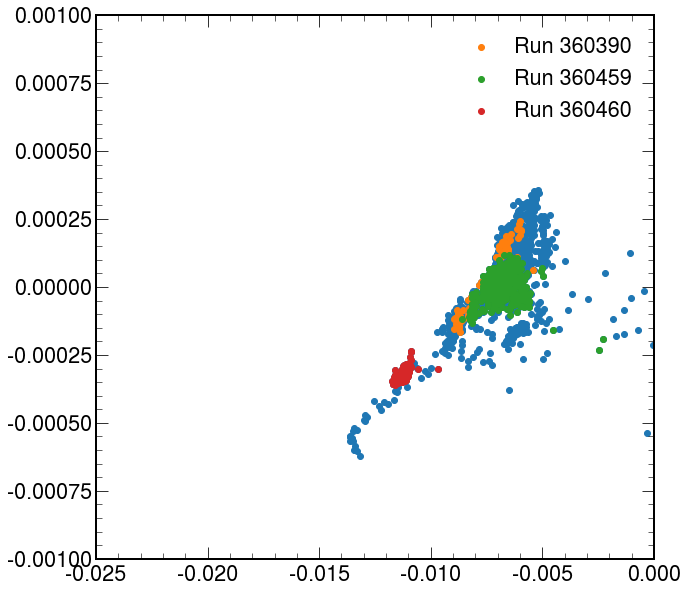

In [49]:
plt.scatter(*(pca_MSEmean_obj.transform([a for _, _, a in differences_list])).transpose())
plt.scatter(*(pca_MSEmean_obj.transform([a for r, _, a in differences_list if r == 360390])).transpose(), label="Run 360390")
plt.scatter(*(pca_MSEmean_obj.transform([a for r, _, a in differences_list if r == 360459])).transpose(), label="Run 360459")
plt.scatter(*(pca_MSEmean_obj.transform([a for r, _, a in differences_list if r == 360460])).transpose(), label="Run 360460")
plt.xlim(-0.025, 0)
plt.ylim(-0.001, 0.001)
plt.legend()

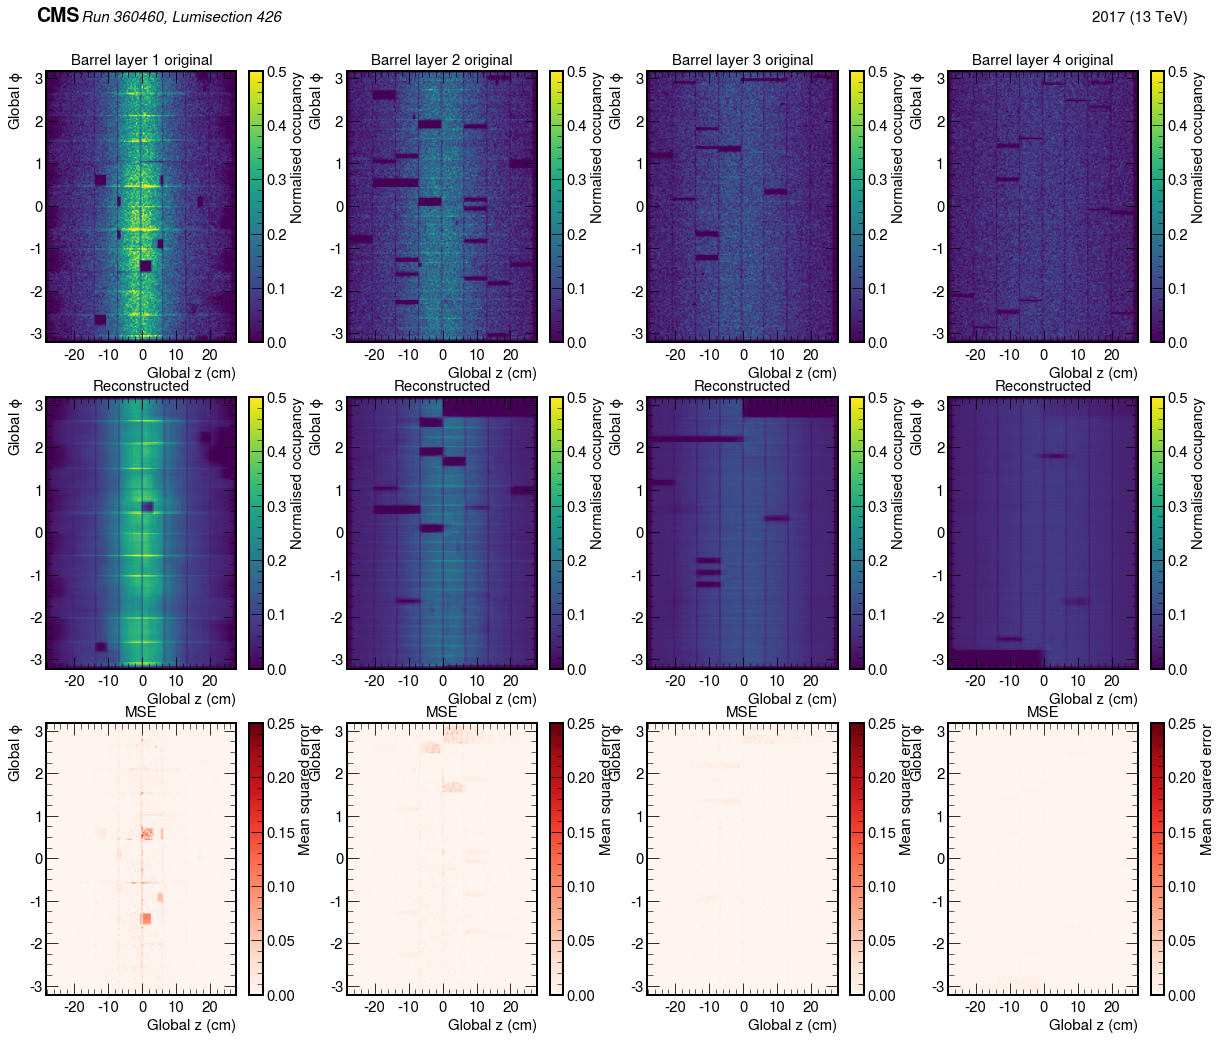

In [53]:
plot_zphi_set(360460, 426)